## Курсовой проект
#### По дисциплине "Методы, средства и технологии мультимедиа"
Выполнил Гаврилов М.С.  
Группа М8О-406Б-19

In [1]:
import pylab
import numpy as np
import copy

import sklearn as skl
from sklearn import datasets
from sklearn.pipeline import Pipeline
from nerus import load_nerus
from tqdm import tqdm

import random

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from matplotlib import gridspec

### Датасет

In [2]:
docs = load_nerus('nerus/nerus_lenta.conllu.gz')

### Постановка задачи 
Методами машинного обучения поздать модель, способную определять часть речи слова русского языка. Для обучения и тестирования используется датасет nerus, алгоритм - случайный лес.

### Анализ датасета и определение признаков
Датасет представляет из себя набор токенизированных предложений. Для решаемой задачи потребуется только слово (в виде текста) и его класс (часть речи). Извечем их.

Определим, какие классы присутствуют в датасете

In [3]:
docs = load_nerus('nerus/nerus_lenta.conllu.gz')

PossibleClasses = []
selLen = 5000 #ограничитель, чтобы проходить не весь датасет, а только часть

for i in range (selLen):
    doc = next(docs)
    
    for sent in doc.sents:
        for token in sent.tokens:
                         
            if(not token.pos in PossibleClasses):
                PossibleClasses.append(token.pos)

print(PossibleClasses)

['NOUN', 'ADP', 'ADJ', 'PROPN', 'VERB', 'PUNCT', 'DET', 'ADV', 'PRON', 'CCONJ', 'SCONJ', 'NUM', 'PART', 'AUX', 'X', 'SYM', 'INTJ']


In [4]:
Classes = PossibleClasses

Вероятно, не все классы подлежат помещению в выборку. Определим, что из себя представляют представлители классов.

['NOUN', 'ADP', 'ADJ', 'PROPN', 'VERB', 'PUNCT', 'DET', 'ADV', 'PRON', 'CCONJ', 'SCONJ', 'NUM', 'PART', 'AUX', 'X', 'SYM', 'INTJ']

In [5]:
docs = load_nerus('nerus/nerus_lenta.conllu.gz')

selLen = 5000 #ограничитель, чтобы проходить не весь датасет, а только часть
ClCnt = np.zeros(len(Classes))
ClExmp = [[] for i in range(len(Classes))]


for i in range (selLen):
    doc = next(docs)
    
    for sent in doc.sents:
        for token in sent.tokens:
                         
            if(ClCnt[PossibleClasses.index(token.pos)] < 5):
                ClCnt[PossibleClasses.index(token.pos)] += 1
                ClExmp[PossibleClasses.index(token.pos)].append(token.text)


In [6]:
for i in range(len(ClExmp)):
    print(PossibleClasses[i])
    for exmpl in ClExmp[i]:
        print("\t{}".format(exmpl))

NOUN
	Вице-премьер
	вопросам
	регионах
	смертность
	рака
ADP
	по
	в
	от
	По
	в
ADJ
	социальным
	высокая
	онкологические
	Псковской
	Тверской
PROPN
	Татьяна
	Голикова
	России
	РИА
	Новости
VERB
	рассказала
	зафиксирована
	сообщает
	становились
	напомнила
PUNCT
	,
	,
	.
	,
	,
DET
	каких
	Каких-либо
	Все
	Таким
	всем
ADV
	наиболее
	чаще
	также
	впервые
	ранее
PRON
	всего
	Это
	этом
	они
	их
CCONJ
	и
	а
	и
	а
	и
SCONJ
	что
	что
	чем
	Как
	как
NUM
	три
	289
	3,5
	меньше
	три
PART
	не
	не
	именно
	ли
	только
AUX
	будет
	были
	было
	была
	был
X
	#
	metoo
	#
	timesup
	marchforourlives
SYM
	+
	+
	&
	+
	№
INTJ
	Фу
	О
	О
	ура
	ура


Подсчитаем частотность классов в датасете

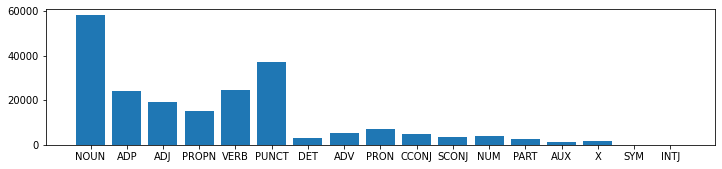

In [7]:
docs = load_nerus('nerus/nerus_lenta.conllu.gz')

ClCnt = np.zeros(len(PossibleClasses))

for i in range (1000):
    doc = next(docs)
    
    for sent in doc.sents:
        for token in sent.tokens:
            if(token.pos in PossibleClasses):
                clN = PossibleClasses.index(token.pos)
                ClCnt[clN] += 1

fig, ax = pylab.subplots()
fig.set_figwidth(12)
fig.set_figheight(2.5) 

ax.bar(PossibleClasses,ClCnt)
pylab.xticks(np.arange(len(PossibleClasses)))
pylab.show()

Определяем классы, которые можно использовать для решения задачи (все, кроме пунктуации, математических действий и 'X')

In [5]:
Classes   = ['NOUN', 'ADP', 'ADJ', 'PROPN', 'VERB', 'DET', 'ADV', 
             'PRON', 'CCONJ', 'SCONJ', 'NUM', 'PART', 'AUX']

Генерируем сбаллансированную выборку (так как в датасете столь много слов, что берется лишь часть)

In [6]:
def create_dataset(selLen = 5000,ClLen = 500,AllowedClasses = Classes,unique = False):
                   #сколько предложений просмотреть
                                 #сколько слов должно быть в каждом классе
                                            #какие части речи добавлять
                                                                      #требуется ли уникальность слов в датасете
        
    ClCnt = np.zeros(len(AllowedClasses))

    larrLB = [] #классы слов
    larrDC = [] #слова
    
    docs = load_nerus('nerus/nerus_lenta.conllu.gz') #заново загружаем датасет

    #Формирование обучающего датасета
    for i in range (selLen):
        doc = next(docs) #идем по предложениям
        
        for sent in doc.sents:
            for token in sent.tokens:
                if(token.pos in AllowedClasses):
                        clN = AllowedClasses.index(token.pos)

                        if(ClCnt[clN] < ClLen):
                            
                            if(unique and token.text in larrDC):
                                continue                                

                            ClCnt[clN] += 1

                            larrLB.append(AllowedClasses.index(token.pos))
                            larrDC.append(token.text)



    ClCnt = np.zeros(len(AllowedClasses))

    tarrLB = []
    tarrDC = []

    #формирование тестового датасета
    for i in range (selLen):
        doc = next(docs)
        
        for sent in doc.sents:
            for token in sent.tokens:
                if(token.pos in AllowedClasses):
                        clN = AllowedClasses.index(token.pos)

                        if(ClCnt[clN] < ClLen):
                            
                            if(unique and (token.text in tarrDC or token.text in larrDC)):
                                continue                    

                            ClCnt[clN] += 1

                            tarrLB.append(AllowedClasses.index(token.pos))
                            tarrDC.append(token.text)

    return np.array(larrLB),np.array(larrDC),np.array(tarrLB),np.array(tarrDC)

In [10]:
larrLB,larrDC,tarrLB,tarrDC = create_dataset(selLen = 10000)

with unique = false
words in train selection:
6500
unique words in train selection:
2191
count of words in dataset per class:


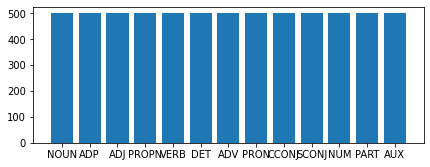

In [11]:
print("with unique = false")
print("words in train selection:")
print(len(larrDC))
print("unique words in train selection:")
print(len(np.unique(larrDC)))

print("count of words in dataset per class:")
fig, ax = pylab.subplots()
fig.set_figwidth(7)
fig.set_figheight(2.5) 

ax.bar(Classes,np.unique(larrLB,return_counts = True)[1])
pylab.xticks(np.arange(len(Classes)))
pylab.show()

## Определение оптимальных признаков.

Предполагаемые признаки:  
- первая буква слова
- последняя буква слова
- предпоследняя буква слова
- длина слова 

Убедимся, что слова разных классов различаются по этим признакам    
Также проверим вторую букву слова и третью с конца букву, возможно, они понадобятся для улучшения точности

In [3]:
alphabet = ['а', 'е', 'ё', 'и', 'о', 'у', 'ы', 'э', 'ю', 'я', 
            'б', 'в', 'г', 'д', 'ж', 'з', 'й', 'к', 'л', 'м', 'н', 'п', 'р', 'с', 'т', 'ф', 'х', 'ц', 'ч', 'ш', 'щ',
            'ь', 'ъ']


FIRST letters by classes


NOUN


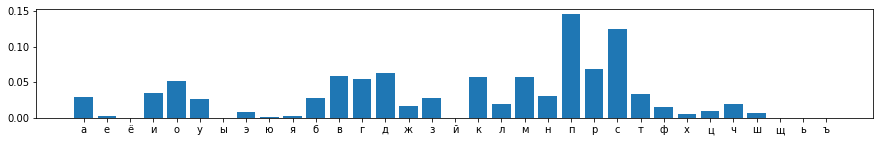

ADP


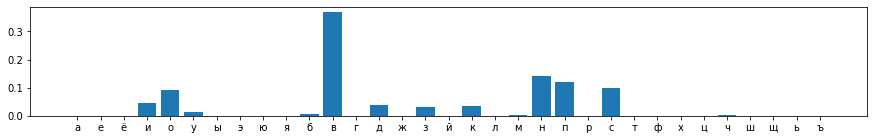

ADJ


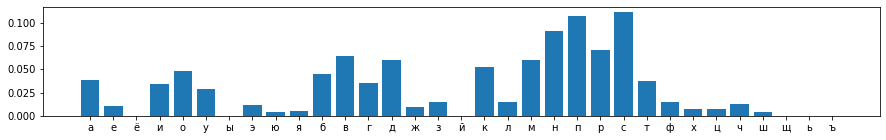

PROPN


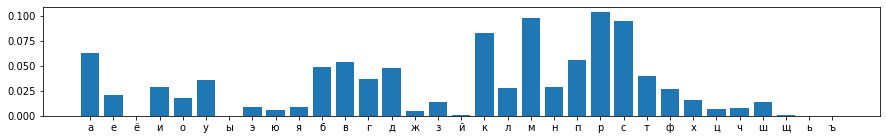

VERB


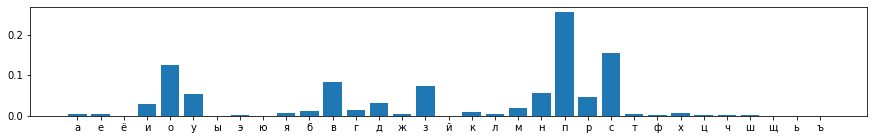

DET


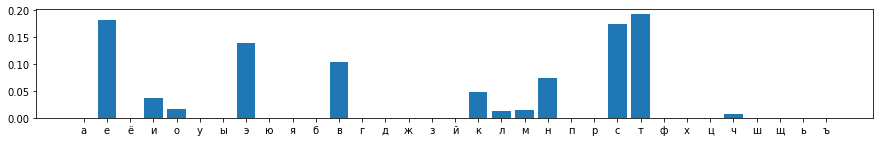

ADV


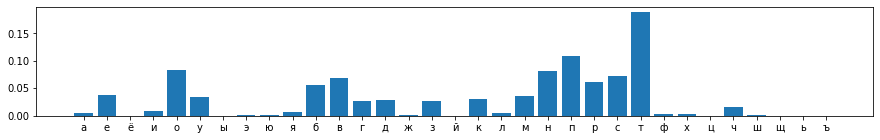

PRON


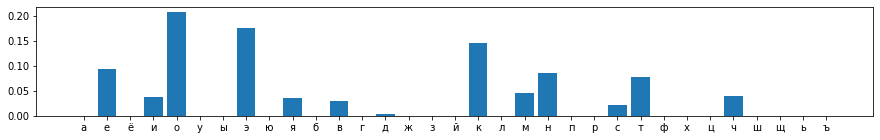

CCONJ


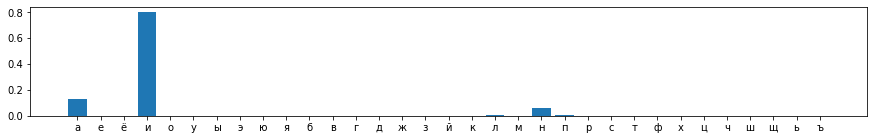

SCONJ


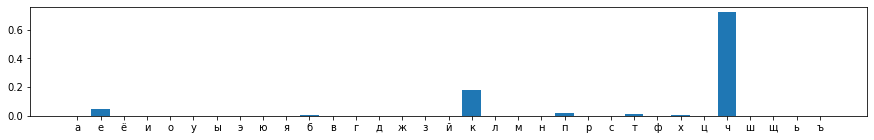

NUM


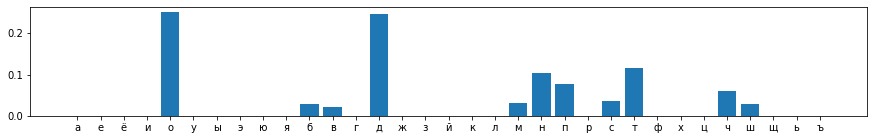

PART


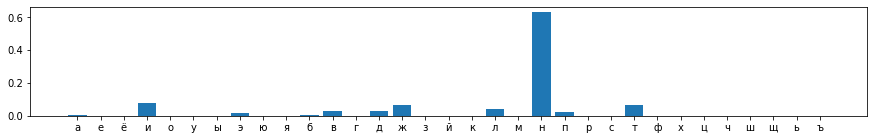

AUX


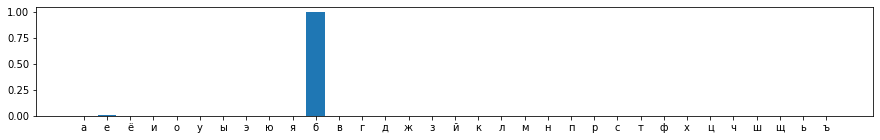

In [15]:
docs = load_nerus('nerus/nerus_lenta.conllu.gz')

ClassFreqFST = np.zeros([len(Classes),len(alphabet)])
ClCnt = np.zeros(len(Classes)) #сколько слов каждого класса встретилось

for i in range (1000):
    doc = next(docs)
    
    for sent in doc.sents:
        for token in sent.tokens:
            if(token.pos in Classes):
                
                try:
                    lp = alphabet.index(token.text.lower()[0])
                except(ValueError):
                    continue
                    
                clN = Classes.index(token.pos)
                                    
                ClassFreqFST[clN][lp] += 1
                ClCnt[clN] += 1
                
for i in range(len(Classes)):
    for j in range(len(alphabet)):
        if(ClCnt[i] != 0):
            ClassFreqFST[i][j] /= ClCnt[i]


print("\nFIRST letters by classes\n\n")

for i in range(len(Classes)): 
    fig, ax = pylab.subplots()
    fig.set_figwidth(15)
    fig.set_figheight(2) 

    print((Classes[i]))
    ax.bar(alphabet,ClassFreqFST[i])
    pylab.xticks(np.arange(33))
    pylab.show()

Функция для вывода диаграмм для двух классов друг возле друга, чтобы их можно было легче сравнить:

In [16]:
def overlay(i,j, freq):
    try:
        s1 = int(i)
    except(BaseException):
        s1 = int(Classes.index(i))
    
    try:
        s2 = int(j)
    except(BaseException):
        s2 = int(Classes.index(j))
        
    
    fig, ax = pylab.subplots()
    fig.set_figwidth(15)
    fig.set_figheight(3) 
    
    a = np.arange(len(alphabet))
    
    ax.bar(a + 0.2,freq[s1],width = 0.4,label = Classes[s1])
    ax.bar(a - 0.2,freq[s2],width = 0.4,label = Classes[s2])
    
    ax.set_xticks(a)
    ax.set_xticklabels(alphabet)
    ax.legend()
    
    pylab.xticks(np.arange(33))
    pylab.show()

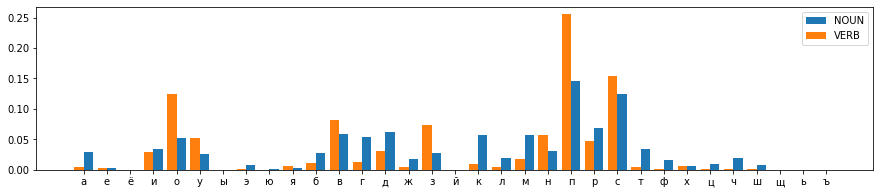

In [17]:
overlay("NOUN","VERB", ClassFreqFST)


LAST letters by classes


NOUN


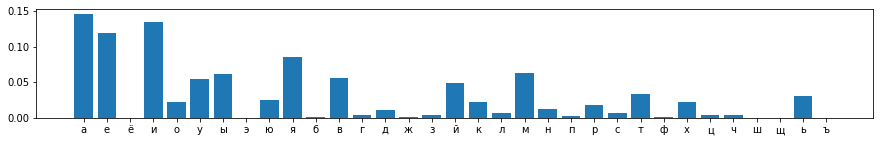

ADP


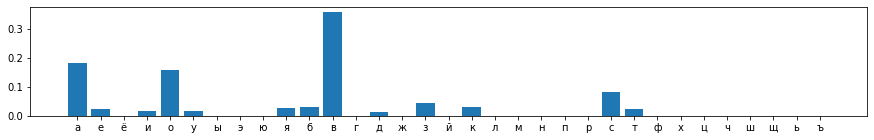

ADJ


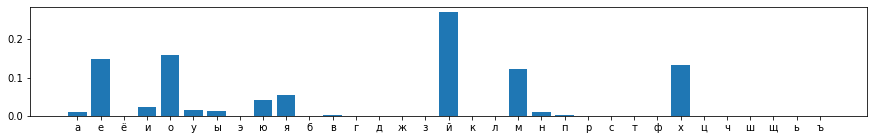

PROPN


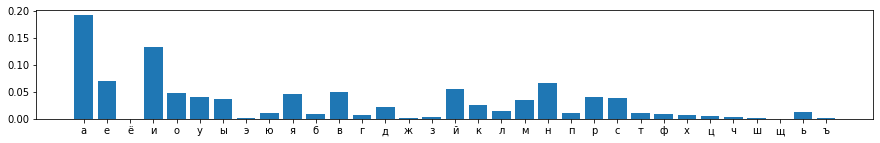

VERB


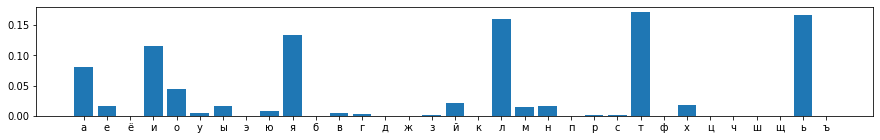

DET


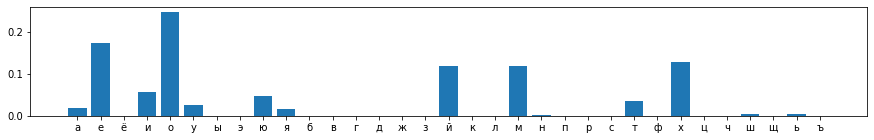

ADV


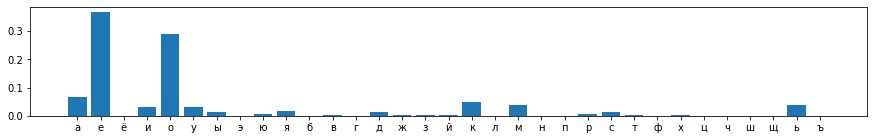

PRON


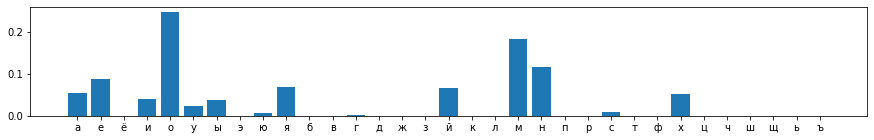

CCONJ


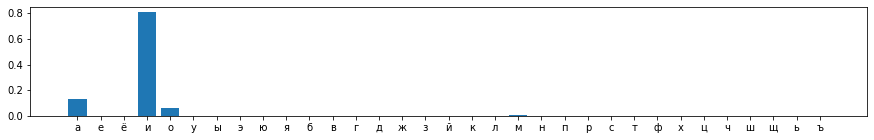

SCONJ


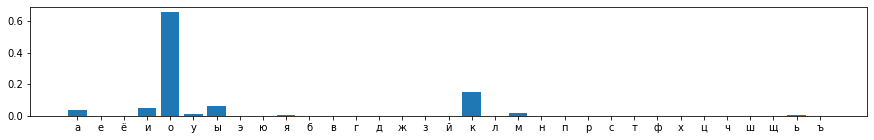

NUM


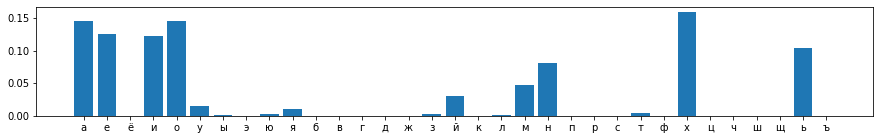

PART


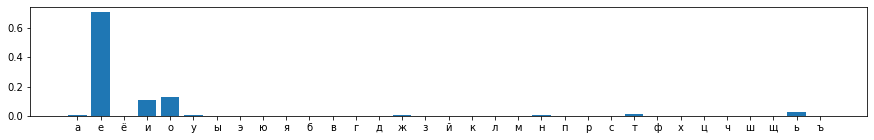

AUX


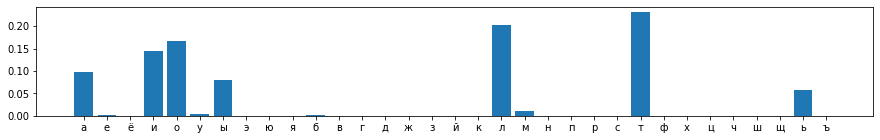

In [18]:
docs = load_nerus('nerus/nerus_lenta.conllu.gz')

ClassFreqLST = np.zeros([len(Classes),len(alphabet)])
ClCnt = np.zeros(len(Classes)) #сколько слов каждого класса встретилось

for i in range (1000):
    doc = next(docs)
    
    for sent in doc.sents:
        for token in sent.tokens:
            if(token.pos in Classes):
                
                try:
                    lp = alphabet.index(token.text.lower()[len(token.text) - 1])
                except(ValueError):
                    continue
                    
                clN = Classes.index(token.pos)
                                    
                ClassFreqLST[clN][lp] += 1
                ClCnt[clN] += 1
                
for i in range(len(Classes)):
    for j in range(len(alphabet)):
        if(ClCnt[i] != 0):
            ClassFreqLST[i][j] /= ClCnt[i]


print("\nLAST letters by classes\n\n")

for i in range(len(Classes)): 
    fig, ax = pylab.subplots()
    fig.set_figwidth(15)
    fig.set_figheight(2) 

    print((Classes[i]))
    ax.bar(alphabet,ClassFreqLST[i])
    pylab.xticks(np.arange(33))
    pylab.show()

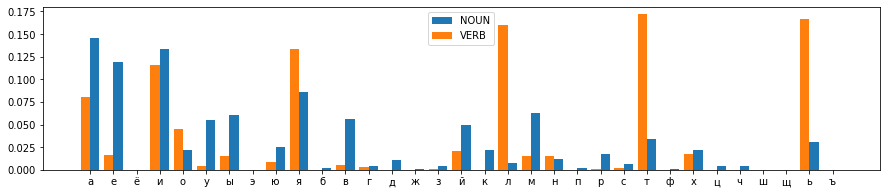

In [19]:
overlay("NOUN","VERB", ClassFreqLST)


2-d LAST letters by classes


NOUN


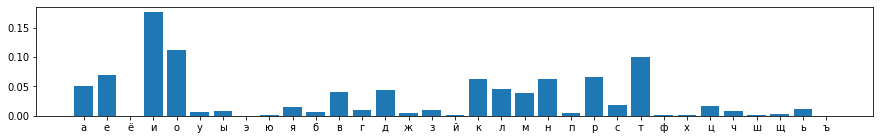

ADP


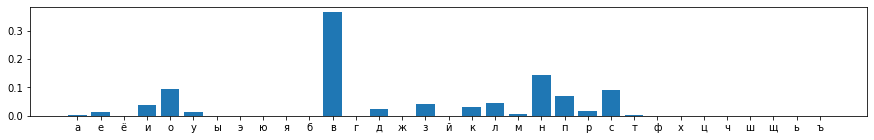

ADJ


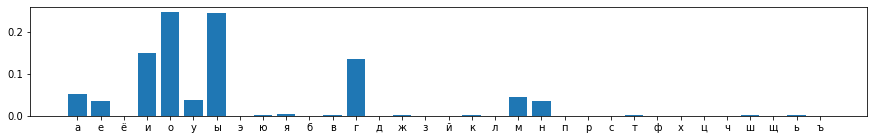

PROPN


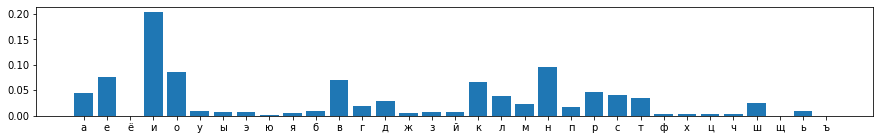

VERB


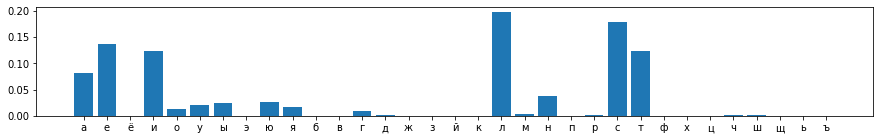

DET


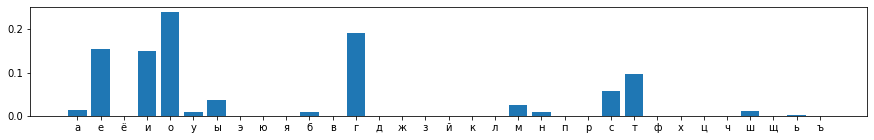

ADV


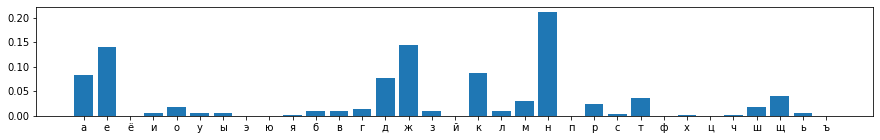

PRON


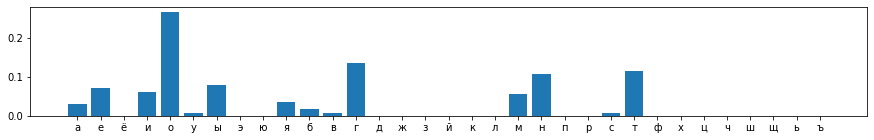

CCONJ


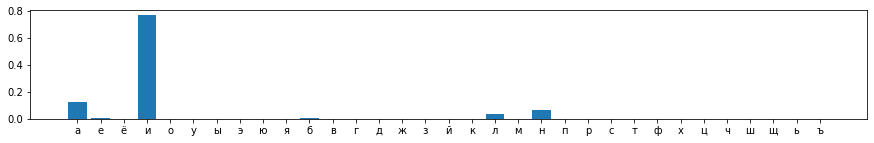

SCONJ


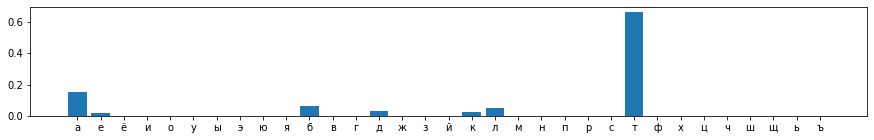

NUM


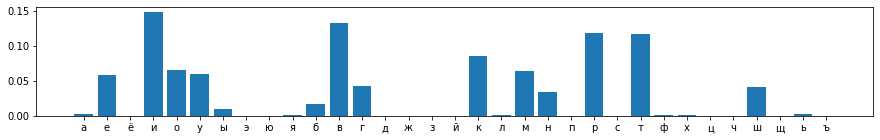

PART


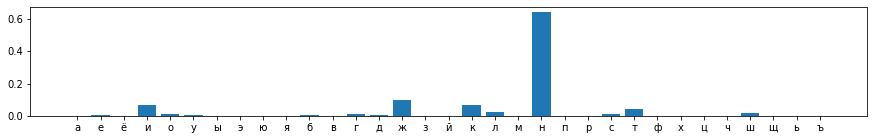

AUX


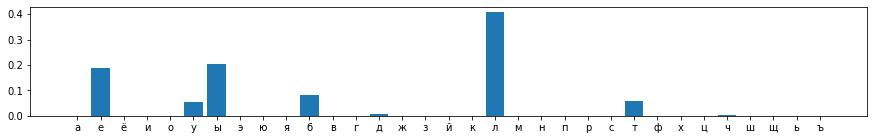

In [20]:
docs = load_nerus('nerus/nerus_lenta.conllu.gz')

ClassFreqLST2 = np.zeros([len(Classes),len(alphabet)])
ClCnt = np.zeros(len(Classes)) #сколько слов каждого класса встретилось

for i in range (1000):
    doc = next(docs)
    
    for sent in doc.sents:
        for token in sent.tokens:
            if(token.pos in Classes):
                
                try:
                    lp = alphabet.index(token.text.lower()[len(token.text) - 2])
                except(ValueError):
                    continue
                    
                clN = Classes.index(token.pos)
                                    
                ClassFreqLST2[clN][lp] += 1
                ClCnt[clN] += 1
                
for i in range(len(Classes)):
    for j in range(len(alphabet)):
        if(ClCnt[i] != 0):
            ClassFreqLST2[i][j] /= ClCnt[i]


print("\n2-d LAST letters by classes\n\n")

for i in range(len(Classes)): 
    fig, ax = pylab.subplots()
    fig.set_figwidth(15)
    fig.set_figheight(2) 

    print((Classes[i]))
    ax.bar(alphabet,ClassFreqLST2[i])
    pylab.xticks(np.arange(33))
    pylab.show()

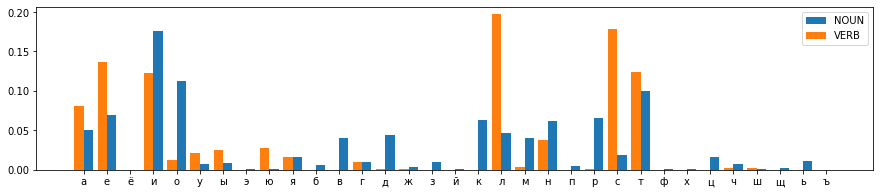

In [21]:
overlay("NOUN","VERB", ClassFreqLST2)

Третья с конца и вторая буквы


2-d FIRST letters by classes


NOUN


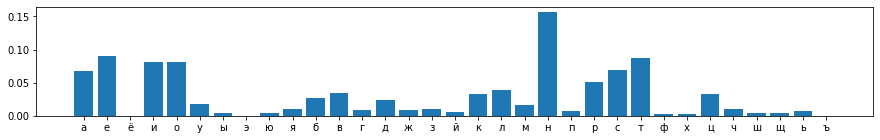

ADP


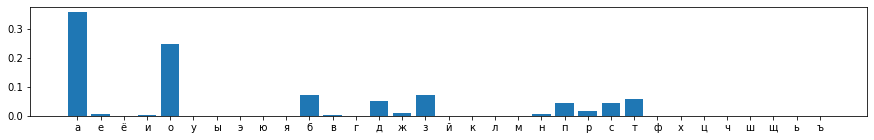

ADJ


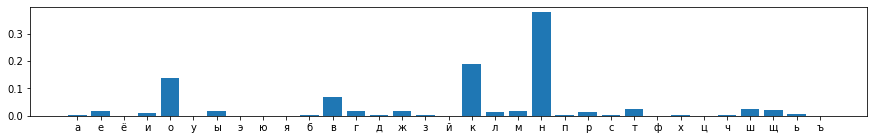

PROPN


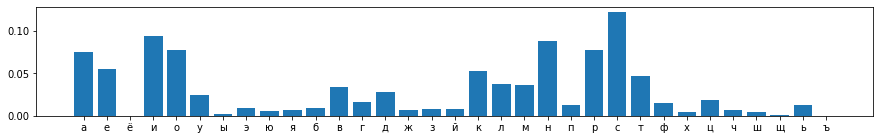

VERB


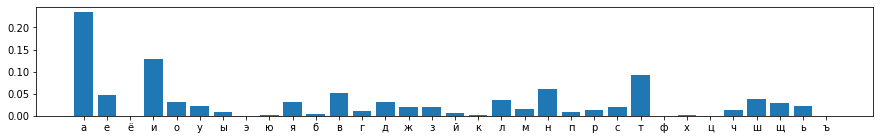

DET


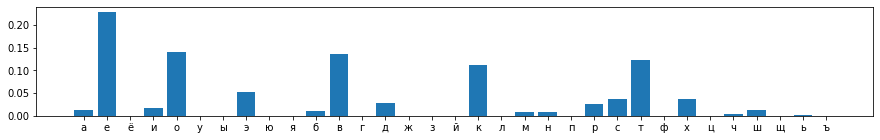

ADV


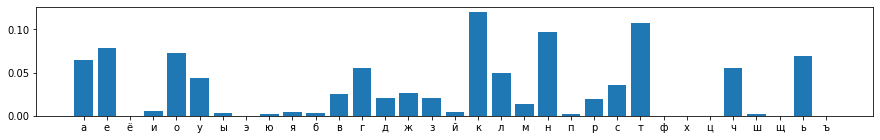

PRON


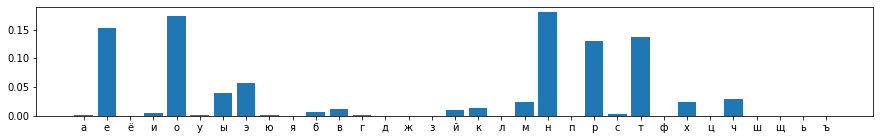

CCONJ


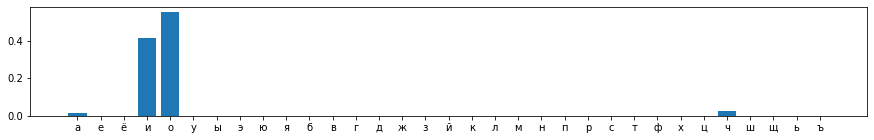

SCONJ


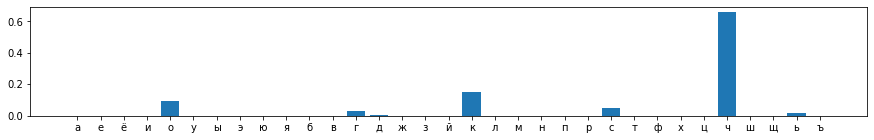

NUM


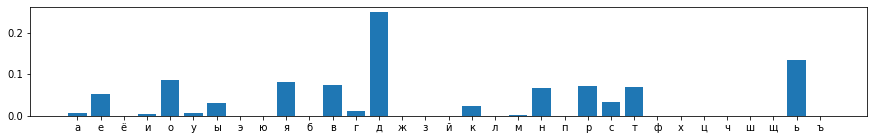

PART


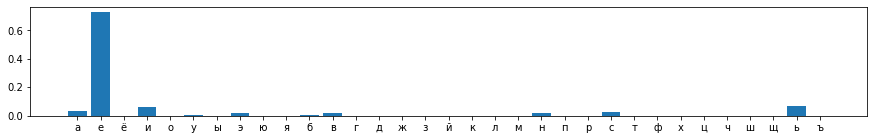

AUX


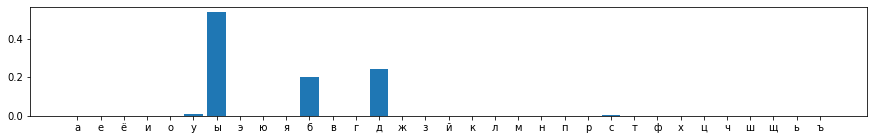

In [22]:
docs = load_nerus('nerus/nerus_lenta.conllu.gz')

ClassFreqSCD = np.zeros([len(Classes),len(alphabet)])
ClCnt = np.zeros(len(Classes)) #сколько слов каждого класса встретилось

for i in range (1000):
    doc = next(docs)
    
    for sent in doc.sents:
        for token in sent.tokens:
            if(token.pos in Classes):
                
                try:
                    lp = alphabet.index(token.text.lower()[len(token.text) - 3])
                except(ValueError):
                    continue
                except(IndexError):
                    continue
                    
                clN = Classes.index(token.pos)
                                    
                ClassFreqSCD[clN][lp] += 1
                ClCnt[clN] += 1
                
for i in range(len(Classes)):
    for j in range(len(alphabet)):
        if(ClCnt[i] != 0):
            ClassFreqSCD[i][j] /= ClCnt[i]


print("\n2-d FIRST letters by classes\n\n")

for i in range(len(Classes)): 
    fig, ax = pylab.subplots()
    fig.set_figwidth(15)
    fig.set_figheight(2) 

    print((Classes[i]))
    ax.bar(alphabet,ClassFreqSCD[i])
    pylab.xticks(np.arange(33))
    pylab.show()

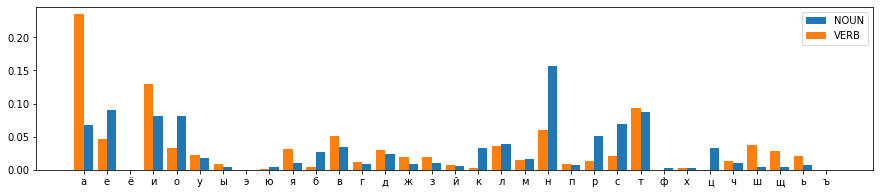

In [23]:
overlay("NOUN","VERB", ClassFreqSCD)


3-d LAST letters by classes


NOUN


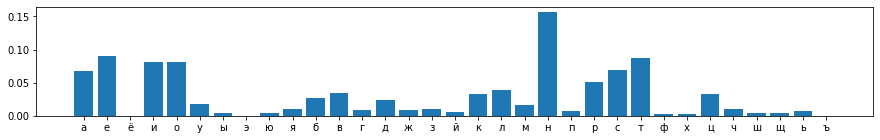

ADP


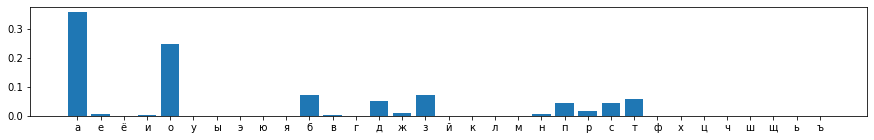

ADJ


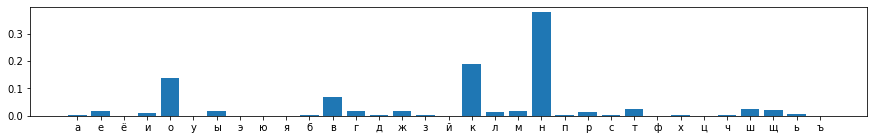

PROPN


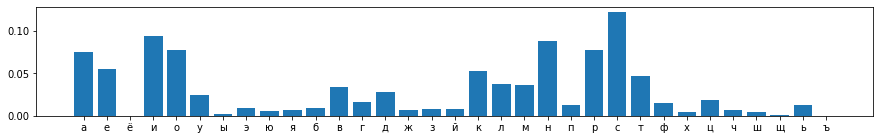

VERB


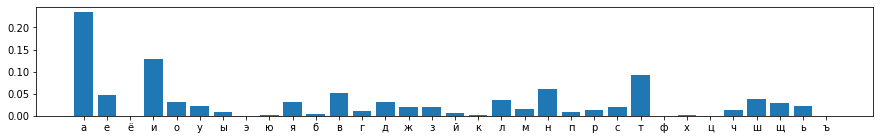

DET


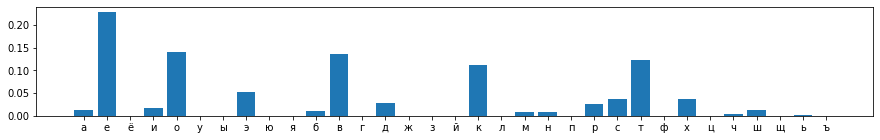

ADV


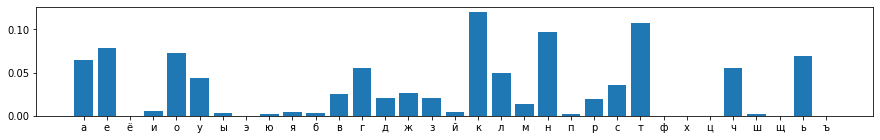

PRON


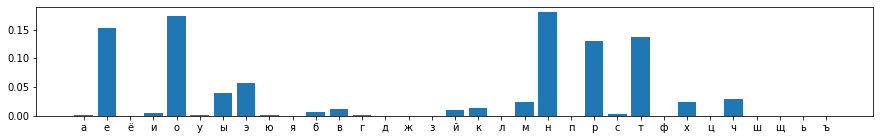

CCONJ


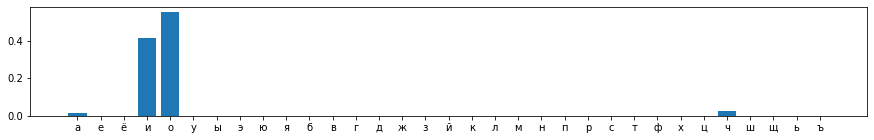

SCONJ


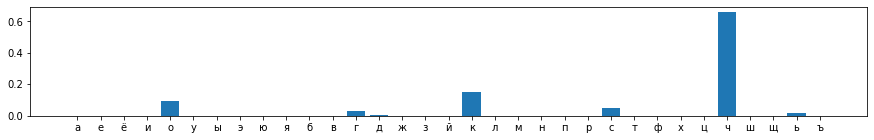

NUM


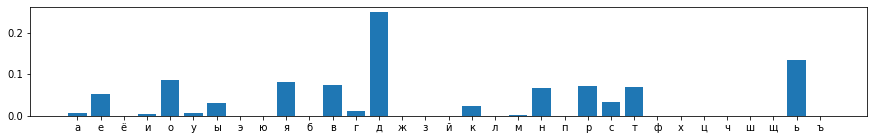

PART


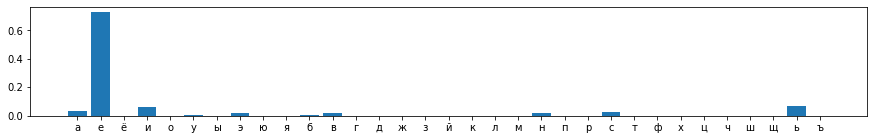

AUX


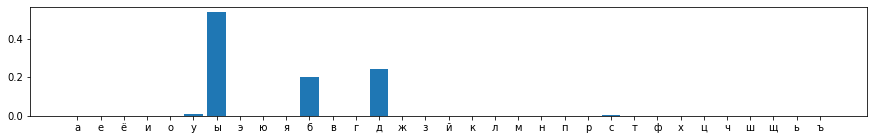

In [24]:
docs = load_nerus('nerus/nerus_lenta.conllu.gz')

ClassFreqLST3 = np.zeros([len(Classes),len(alphabet)])
ClCnt = np.zeros(len(Classes)) #сколько слов каждого класса встретилось

for i in range (1000):
    doc = next(docs)
    
    for sent in doc.sents:
        for token in sent.tokens:
            if(token.pos in Classes):
                
                try:
                    lp = alphabet.index(token.text.lower()[len(token.text) - 3])
                except(ValueError):
                    continue
                except(IndexError):
                    continue
                    
                clN = Classes.index(token.pos)
                                    
                ClassFreqLST3[clN][lp] += 1
                ClCnt[clN] += 1
                
for i in range(len(Classes)):
    for j in range(len(alphabet)):
        if(ClCnt[i] != 0):
            ClassFreqLST3[i][j] /= ClCnt[i]


print("\n3-d LAST letters by classes\n\n")

for i in range(len(Classes)): 
    fig, ax = pylab.subplots()
    fig.set_figwidth(15)
    fig.set_figheight(2) 

    print((Classes[i]))
    ax.bar(alphabet,ClassFreqLST3[i])
    pylab.xticks(np.arange(33))
    pylab.show()

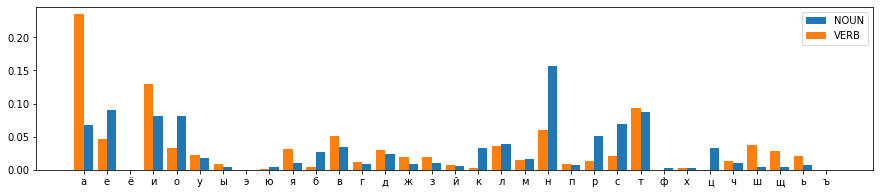

In [25]:
overlay("NOUN","VERB", ClassFreqLST3)

Длина слов по классам 


AVG length by classes


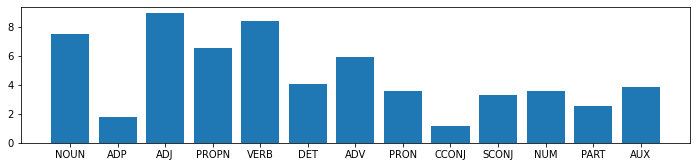

In [26]:
docs = load_nerus('nerus/nerus_lenta.conllu.gz')

ClCnt = np.zeros(len(Classes))
CllenAvg = np.zeros(len(Classes))

for i in range (1000):
    doc = next(docs)
    
    for sent in doc.sents:
        for token in sent.tokens:
            if(token.pos in Classes):
                clN = Classes.index(token.pos)
                CllenAvg[clN] += len(token.text)
                ClCnt[clN] += 1
                
for i in range(len(Classes)):
    CllenAvg[i] /= ClCnt[i]
             
print("\nAVG length by classes")
        
fig, ax = pylab.subplots()
fig.set_figwidth(12)
fig.set_figheight(2.5) 

ax.bar(Classes,CllenAvg)
pylab.xticks(np.arange(len(Classes)))
pylab.show()

Убедившись, что предлагаемыве признаки действительно отличаются у различных классов, приступим к построению модели

### Обработка данных
Мы не можем передавать на вход модели сами слова, необходимо выделить из них признаки.  
Для этого используем инструмент skl pipeline и skl Transformer.

In [14]:
def LetterPos(letter):
    try:
        return alphabet.index(letter)
    except(ValueError):
        return -1

def CarArr(_word,mult = 1):
    word = copy.deepcopy(_word)
    
    if(len(word) < 3):
        res = np.array([
                        len(word),
                        LetterPos(word[0])*mult,
                        (-1)*mult,
                        LetterPos((word[len(word) - 2]))*mult,
                        LetterPos((word[len(word) - 1]))*mult
                        ], dtype = object)
    else:
        res = np.array([
                        len(word),
                        LetterPos(word[0])*mult,
                        LetterPos((word[len(word) - 3]))*mult,
                        LetterPos((word[len(word) - 2]))*mult,
                        LetterPos(word[len(word) - 1])*mult
                        ], dtype = object)
    return res

class transform(skl.base.TransformerMixin):
    
    def __init__(self,n = 1):
        self.n = n
    
    def fit(self,a,b):
        return self
    
    def transform(self,a):
        res = copy.deepcopy(a)
        for i in range(len(a)):
            res[i] = CarArr(a[i], mult = self.n)
            
        return np.array(res)

Функция transform извлекает буквы слов на нужных позициях, берет их позицию в алфавите и, комбинируя с длиной слова, формирует вектор признаков.  
Пример:

In [24]:
transform().transform(["кета"])

array([[4, 17, 1, 24, 0]], dtype=object)

### Обучение моделей из skl

При оценки точности используется кросс-валидация случайными разбиениями

In [15]:
class RCV():
    
    def __init__(self,arr_train,arr_test,pipe = None):
        self.train_X = arr_train[0]
        self.train_L = arr_train[1]
        self.test_X = arr_train[0]
        self.test_L = arr_train[1]
        self.pipe = pipe
        
    def apply_model(self,pipe):
        self.pipe = pipe
    
    def validate(self,i = 10,pipe = None,ratio = 0.5,verbal = False,do_train = False):
        if(pipe == None):
            pipe = self.pipe
        if(pipe == None):
            return None
                
        arr_train = []
        arr_test = []
        validation_array_X = np.concatenate([self.train_X,self.test_X],axis = 0)
        validation_array_Y = np.concatenate([self.train_L,self.test_L],axis = 0)
        
        for j in range(i):
            cur_validation_array_X, cur_validation_array_Y = skl.utils.shuffle(validation_array_X,validation_array_Y)
            train_X,test_X = np.split(cur_validation_array_X,
                                      [int(len(cur_validation_array_X)*ratio)])
            train_L,test_L = np.split(cur_validation_array_Y,
                                      [int(len(cur_validation_array_Y)*ratio)])
            
            train_X = train_X.tolist()
            train_L = train_L.tolist()
            
            test_X = test_X.tolist()
            test_L = test_L.tolist()
            
            self.pipe.fit(train_X,train_L)
            score_train = self.pipe.score(train_X,train_L)
            score_test = self.pipe.score(test_X,test_L)
            arr_train.append(score_train)
            arr_test.append(score_test)
            
            if(verbal):
                print("test {} of {} | done".format(j,i))
        
        if(do_train):
            return np.array(arr_train,dtype=object), np.array(arr_test,dtype=object)
        else:
            return np.array(arr_test,dtype=object)

Выбранные метрики - точность, малрица спутывания и отчет по классификации из skl, который ввключает в себя preision, recall и f1 для каждого класса

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [8]:
larrLB,larrDC,tarrLB,tarrDC = create_dataset(AllowedClasses = Classes,unique = False)

In [32]:
rf = RandomForestClassifier()
pipe = Pipeline([('transformer',transform()),('classifier',rf)])
CrossValidataion = RCV([larrDC,larrLB],[tarrDC,tarrLB],pipe = pipe)
arr = CrossValidataion.validate(i = 30,ratio = 0.95,verbal = False)
mean_score = np.mean(arr)

score on train set
0.935076923076923
score on test set
0.8547692307692307
Confusion matrix for train_set


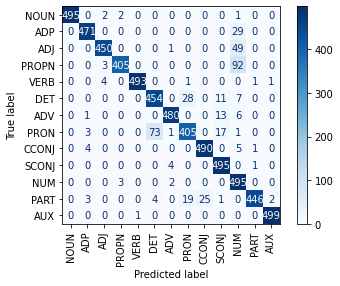

Confusion matrix for test_set


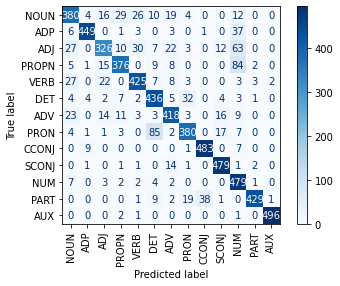

for train set:

              precision    recall  f1-score   support

        NOUN       1.00      0.99      0.99       500
         ADP       0.98      0.94      0.96       500
         ADJ       0.98      0.90      0.94       500
       PROPN       0.99      0.81      0.89       500
        VERB       1.00      0.99      0.99       500
         DET       0.85      0.91      0.88       500
         ADV       0.98      0.96      0.97       500
        PRON       0.89      0.81      0.85       500
       CCONJ       0.95      0.98      0.97       500
       SCONJ       0.92      0.99      0.95       500
         NUM       0.72      0.99      0.84       500
        PART       0.99      0.89      0.94       500
         AUX       0.99      1.00      1.00       500

    accuracy                           0.94      6500
   macro avg       0.94      0.94      0.94      6500
weighted avg       0.94      0.94      0.94      6500

for test set:

              precision    recall  f1-score   su

In [33]:
rf = RandomForestClassifier()
pipe = Pipeline([('transformer',transform()),('classifier',rf)])
pipe.fit(larrDC.tolist(),larrLB.tolist())
print("score on train set")
print(pipe.score(larrDC.tolist(),larrLB.tolist()))
print("score on test set")
print(pipe.score(tarrDC.tolist(),tarrLB.tolist()))

larrPD = np.array([pipe.predict([elm])[0] for elm in larrDC])
tarrPD = np.array([pipe.predict([elm])[0] for elm in tarrDC])

print("Confusion matrix for train_set")
ConfusionMatrixDisplay.from_predictions(larrLB,larrPD,display_labels = np.array(Classes),cmap = 'Blues',
                                        xticks_rotation = 'vertical')
pylab.show()

print("Confusion matrix for test_set")
ConfusionMatrixDisplay.from_predictions(tarrLB,tarrPD,display_labels = np.array(Classes),cmap = 'Blues',
                                        xticks_rotation = 'vertical')
pylab.show()

print("for train set:\n")
print(classification_report(larrLB,larrPD,target_names = np.array(Classes)))
print("for test set:\n")
print(classification_report(tarrLB,tarrPD,target_names = np.array(Classes)))

### Оценка других классификаторов skl

#### Решающее дерево

score on train set
0.935076923076923
score on test set
0.8315384615384616
Confusion matrix for train_set


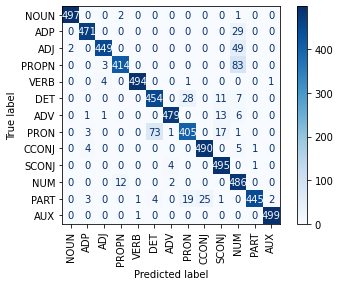

Confusion matrix for test_set


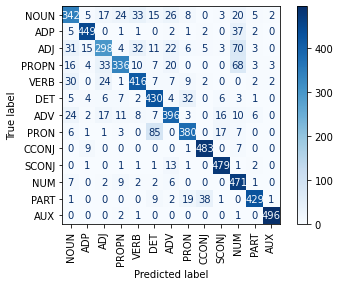

for train set:

              precision    recall  f1-score   support

        NOUN       1.00      0.99      0.99       500
         ADP       0.98      0.94      0.96       500
         ADJ       0.98      0.90      0.94       500
       PROPN       0.97      0.83      0.89       500
        VERB       1.00      0.99      0.99       500
         DET       0.85      0.91      0.88       500
         ADV       0.99      0.96      0.97       500
        PRON       0.89      0.81      0.85       500
       CCONJ       0.95      0.98      0.97       500
       SCONJ       0.92      0.99      0.95       500
         NUM       0.73      0.97      0.83       500
        PART       1.00      0.89      0.94       500
         AUX       0.99      1.00      1.00       500

    accuracy                           0.94      6500
   macro avg       0.94      0.94      0.94      6500
weighted avg       0.94      0.94      0.94      6500

for test set:

              precision    recall  f1-score   su

In [34]:
dt = DecisionTreeClassifier()
pipe = Pipeline([('transformer',transform()),('classifier',dt)])
pipe.fit(larrDC.tolist(),larrLB.tolist())
print("score on train set")
print(pipe.score(larrDC.tolist(),larrLB.tolist()))
print("score on test set")
print(pipe.score(tarrDC.tolist(),tarrLB.tolist()))

larrPD = np.array([pipe.predict([elm])[0] for elm in larrDC])
tarrPD = np.array([pipe.predict([elm])[0] for elm in tarrDC])

print("Confusion matrix for train_set")
ConfusionMatrixDisplay.from_predictions(larrLB,larrPD,display_labels = np.array(Classes),cmap = 'Blues',
                                        xticks_rotation = 'vertical')
pylab.show()

print("Confusion matrix for test_set")
ConfusionMatrixDisplay.from_predictions(tarrLB,tarrPD,display_labels = np.array(Classes),cmap = 'Blues',
                                        xticks_rotation = 'vertical')
pylab.show()

print("for train set:\n")
print(classification_report(larrLB,larrPD,target_names = np.array(Classes)))
print("for test set:\n")
print(classification_report(tarrLB,tarrPD,target_names = np.array(Classes)))

#### Логистическая регрессия

C:\Users\max\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


score on train set
0.4586153846153846
score on test set
0.4503076923076923
Confusion matrix for train_set


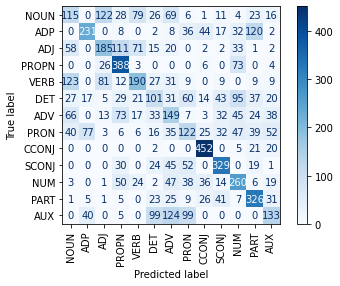

Confusion matrix for test_set


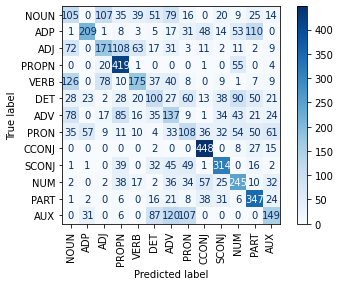

for train set:

              precision    recall  f1-score   support

        NOUN       0.27      0.23      0.25       500
         ADP       0.62      0.46      0.53       500
         ADJ       0.42      0.37      0.39       500
       PROPN       0.52      0.78      0.62       500
        VERB       0.46      0.38      0.42       500
         DET       0.27      0.20      0.23       500
         ADV       0.26      0.30      0.27       500
        PRON       0.28      0.24      0.26       500
       CCONJ       0.74      0.90      0.82       500
       SCONJ       0.62      0.66      0.64       500
         NUM       0.43      0.52      0.47       500
        PART       0.52      0.65      0.58       500
         AUX       0.38      0.27      0.31       500

    accuracy                           0.46      6500
   macro avg       0.45      0.46      0.45      6500
weighted avg       0.45      0.46      0.45      6500

for test set:

              precision    recall  f1-score   su

In [35]:
lr = LogisticRegression()
pipe = Pipeline([('transformer',transform()),('classifier',lr)])
pipe.fit(larrDC.tolist(),larrLB.tolist())
print("score on train set")
print(pipe.score(larrDC.tolist(),larrLB.tolist()))
print("score on test set")
print(pipe.score(tarrDC.tolist(),tarrLB.tolist()))

larrPD = np.array([pipe.predict([elm])[0] for elm in larrDC])
tarrPD = np.array([pipe.predict([elm])[0] for elm in tarrDC])

print("Confusion matrix for train_set")
ConfusionMatrixDisplay.from_predictions(larrLB,larrPD,display_labels = np.array(Classes),cmap = 'Blues',
                                        xticks_rotation = 'vertical')
pylab.show()

print("Confusion matrix for test_set")
ConfusionMatrixDisplay.from_predictions(tarrLB,tarrPD,display_labels = np.array(Classes),cmap = 'Blues',
                                        xticks_rotation = 'vertical')
pylab.show()

print("for train set:\n")
print(classification_report(larrLB,larrPD,target_names = np.array(Classes)))
print("for test set:\n")
print(classification_report(tarrLB,tarrPD,target_names = np.array(Classes)))

#### Наивный байесовский классификатор

score on train set
0.48415384615384616
score on test set
0.47
Confusion matrix for train_set


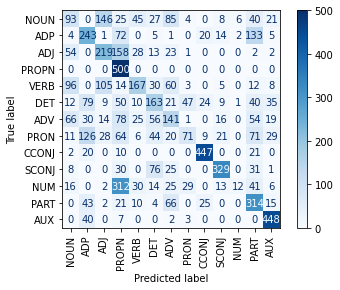

Confusion matrix for test_set


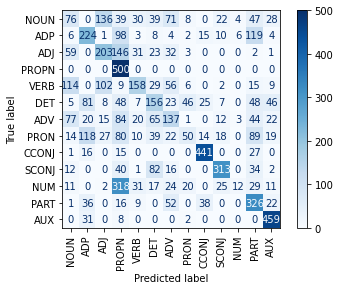

for train set:

              precision    recall  f1-score   support

        NOUN       0.26      0.19      0.22       500
         ADP       0.42      0.49      0.45       500
         ADJ       0.42      0.44      0.43       500
       PROPN       0.37      1.00      0.54       500
        VERB       0.52      0.33      0.41       500
         DET       0.38      0.33      0.35       500
         ADV       0.30      0.28      0.29       500
        PRON       0.45      0.14      0.22       500
       CCONJ       0.85      0.89      0.87       500
       SCONJ       0.79      0.66      0.72       500
         NUM       0.57      0.02      0.05       500
        PART       0.41      0.63      0.50       500
         AUX       0.76      0.90      0.82       500

    accuracy                           0.48      6500
   macro avg       0.50      0.48      0.45      6500
weighted avg       0.50      0.48      0.45      6500

for test set:

              precision    recall  f1-score   su

In [36]:
nb = GaussianNB()
pipe = Pipeline([('transformer',transform()),('classifier',nb)])
pipe.fit(larrDC.tolist(),larrLB.tolist())
print("score on train set")
print(pipe.score(larrDC.tolist(),larrLB.tolist()))
print("score on test set")
print(pipe.score(tarrDC.tolist(),tarrLB.tolist()))

larrPD = np.array([pipe.predict([elm])[0] for elm in larrDC])
tarrPD = np.array([pipe.predict([elm])[0] for elm in tarrDC])

print("Confusion matrix for train_set")
ConfusionMatrixDisplay.from_predictions(larrLB,larrPD,display_labels = np.array(Classes),cmap = 'Blues',
                                        xticks_rotation = 'vertical')
pylab.show()

print("Confusion matrix for test_set")
ConfusionMatrixDisplay.from_predictions(tarrLB,tarrPD,display_labels = np.array(Classes),cmap = 'Blues',
                                        xticks_rotation = 'vertical')
pylab.show()

print("for train set:\n")
print(classification_report(larrLB,larrPD,target_names = np.array(Classes)))
print("for test set:\n")
print(classification_report(tarrLB,tarrPD,target_names = np.array(Classes)))

#### KNN

score on train set
0.8318461538461538
score on test set
0.7698461538461538
Confusion matrix for train_set


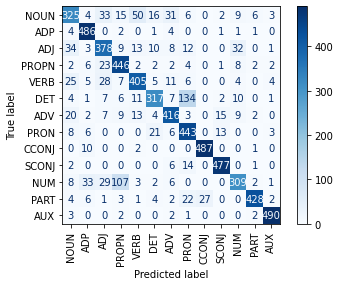

Confusion matrix for test_set


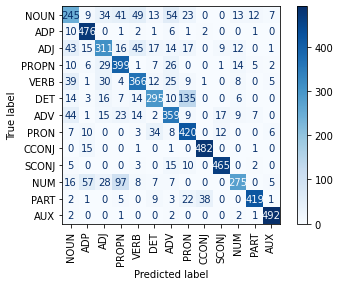

for train set:

              precision    recall  f1-score   support

        NOUN       0.74      0.65      0.69       500
         ADP       0.86      0.97      0.92       500
         ADJ       0.75      0.76      0.75       500
       PROPN       0.74      0.89      0.81       500
        VERB       0.81      0.81      0.81       500
         DET       0.83      0.63      0.72       500
         ADV       0.83      0.83      0.83       500
        PRON       0.69      0.89      0.77       500
       CCONJ       0.95      0.97      0.96       500
       SCONJ       0.93      0.95      0.94       500
         NUM       0.81      0.62      0.70       500
        PART       0.96      0.86      0.91       500
         AUX       0.97      0.98      0.97       500

    accuracy                           0.83      6500
   macro avg       0.84      0.83      0.83      6500
weighted avg       0.84      0.83      0.83      6500

for test set:

              precision    recall  f1-score   su

In [37]:
knn = KNeighborsClassifier()
pipe = Pipeline([('transformer',transform()),('classifier',knn)])
pipe.fit(larrDC.tolist(),larrLB.tolist())
print("score on train set")
print(pipe.score(larrDC.tolist(),larrLB.tolist()))
print("score on test set")
print(pipe.score(tarrDC.tolist(),tarrLB.tolist()))

larrPD = np.array([pipe.predict([elm])[0] for elm in larrDC])
tarrPD = np.array([pipe.predict([elm])[0] for elm in tarrDC])

print("Confusion matrix for train_set")
ConfusionMatrixDisplay.from_predictions(larrLB,larrPD,display_labels = np.array(Classes),cmap = 'Blues',
                                        xticks_rotation = 'vertical')
pylab.show()

print("Confusion matrix for test_set")
ConfusionMatrixDisplay.from_predictions(tarrLB,tarrPD,display_labels = np.array(Classes),cmap = 'Blues',
                                        xticks_rotation = 'vertical')
pylab.show()

print("for train set:\n")
print(classification_report(larrLB,larrPD,target_names = np.array(Classes)))
print("for test set:\n")
print(classification_report(tarrLB,tarrPD,target_names = np.array(Classes)))

#### KNN с k = 1

score on train set
0.8810769230769231
score on test set
0.7566153846153846
Confusion matrix for train_set


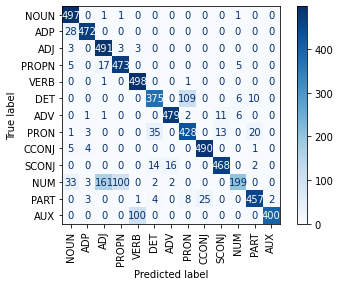

Confusion matrix for test_set


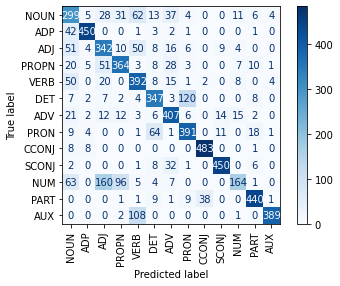

for train set:

              precision    recall  f1-score   support

        NOUN       0.87      0.99      0.93       500
         ADP       0.97      0.94      0.96       500
         ADJ       0.73      0.98      0.84       500
       PROPN       0.82      0.95      0.88       500
        VERB       0.83      1.00      0.90       500
         DET       0.87      0.75      0.81       500
         ADV       0.96      0.96      0.96       500
        PRON       0.78      0.86      0.82       500
       CCONJ       0.95      0.98      0.97       500
       SCONJ       0.95      0.94      0.94       500
         NUM       0.92      0.40      0.56       500
        PART       0.93      0.91      0.92       500
         AUX       1.00      0.80      0.89       500

    accuracy                           0.88      6500
   macro avg       0.89      0.88      0.87      6500
weighted avg       0.89      0.88      0.87      6500

for test set:

              precision    recall  f1-score   su

In [38]:
knn = KNeighborsClassifier(n_neighbors = 1)
pipe = Pipeline([('transformer',transform()),('classifier',knn)])
pipe.fit(larrDC.tolist(),larrLB.tolist())
print("score on train set")
print(pipe.score(larrDC.tolist(),larrLB.tolist()))
print("score on test set")
print(pipe.score(tarrDC.tolist(),tarrLB.tolist()))

larrPD = np.array([pipe.predict([elm])[0] for elm in larrDC])
tarrPD = np.array([pipe.predict([elm])[0] for elm in tarrDC])

print("Confusion matrix for train_set")
ConfusionMatrixDisplay.from_predictions(larrLB,larrPD,display_labels = np.array(Classes),cmap = 'Blues',
                                        xticks_rotation = 'vertical')
pylab.show()

print("Confusion matrix for test_set")
ConfusionMatrixDisplay.from_predictions(tarrLB,tarrPD,display_labels = np.array(Classes),cmap = 'Blues',
                                        xticks_rotation = 'vertical')
pylab.show()

print("for train set:\n")
print(classification_report(larrLB,larrPD,target_names = np.array(Classes)))
print("for test set:\n")
print(classification_report(tarrLB,tarrPD,target_names = np.array(Classes)))

#### Градиентный бустинг

score on train set
0.8689230769230769
score on test set
0.826
Confusion matrix for train_set


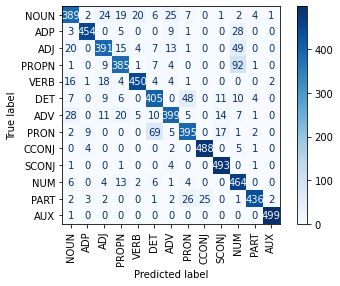

Confusion matrix for test_set


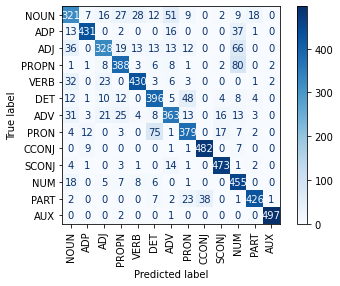

for train set:

              precision    recall  f1-score   support

        NOUN       0.82      0.78      0.80       500
         ADP       0.96      0.91      0.93       500
         ADJ       0.84      0.78      0.81       500
       PROPN       0.82      0.77      0.80       500
        VERB       0.93      0.90      0.92       500
         DET       0.79      0.81      0.80       500
         ADV       0.85      0.80      0.82       500
        PRON       0.81      0.79      0.80       500
       CCONJ       0.95      0.98      0.96       500
       SCONJ       0.92      0.99      0.95       500
         NUM       0.70      0.93      0.80       500
        PART       0.97      0.87      0.92       500
         AUX       0.99      1.00      0.99       500

    accuracy                           0.87      6500
   macro avg       0.87      0.87      0.87      6500
weighted avg       0.87      0.87      0.87      6500

for test set:

              precision    recall  f1-score   su

In [39]:
gb = GradientBoostingClassifier()
pipe = Pipeline([('transformer',transform()),('classifier',gb)])
pipe.fit(larrDC.tolist(),larrLB.tolist())
print("score on train set")
print(pipe.score(larrDC.tolist(),larrLB.tolist()))
print("score on test set")
print(pipe.score(tarrDC.tolist(),tarrLB.tolist()))

larrPD = np.array([pipe.predict([elm])[0] for elm in larrDC])
tarrPD = np.array([pipe.predict([elm])[0] for elm in tarrDC])

print("Confusion matrix for train_set")
ConfusionMatrixDisplay.from_predictions(larrLB,larrPD,display_labels = np.array(Classes),cmap = 'Blues',
                                        xticks_rotation = 'vertical')
pylab.show()

print("Confusion matrix for test_set")
ConfusionMatrixDisplay.from_predictions(tarrLB,tarrPD,display_labels = np.array(Classes),cmap = 'Blues',
                                        xticks_rotation = 'vertical')
pylab.show()

print("for train set:\n")
print(classification_report(larrLB,larrPD,target_names = np.array(Classes)))
print("for test set:\n")
print(classification_report(tarrLB,tarrPD,target_names = np.array(Classes)))

Ни один из прочих алгоритмов машинного обучения не показал столь же высокой точности на стандартных параметрах, что случайный лес.

### Собственная реализация алгоритма

Моя версия алгоритма включает в себя реализацию дерева принятия решений, выполняющего разбиения по случайно выбраным призакам, а также реализацию бутстрапа.  
Сам случайный лес - это ансамбль, состоящий из n_trees trees_count деревьев, каждое из которых выполняет биения до глубины max_depth, и получает для обучения случаюную подвыборку размером sel_size, формируемую бутстрапом.  
Вероятность того, что признак попадет в подборку признаков для биения при обучении случайных деревьев определяется параметром dropout.  
При классификации элементу присваивается класс, предсказанный большинством деревьев (hard voting)

In [9]:
def bootstrap(data_X_,data_L_,num_sel,sel_size = None):
    #по умолчанию бьет выборку на равные части (случайно выбирая элементы с повторением)
    #sel size в пределах от 0 до 1 задает размер частей относительно общего размера выборки
    #sel size больше 1 задает абсолютный размер частей
    data_X,data_L = skl.utils.shuffle(data_X_,data_L_)
    if(sel_size == None):
        sel_size = int(len(data_X) / num_sel)
    if(sel_size <= 1):
        sel_size = int(sel_size*len(data_X))
        
    mod_base = [[data_X[i],data_L[i]] for i in range(len(data_X))]
    
    all_sel = []
    for k in range(num_sel):
        cur_sel = []
        for i in range(sel_size):
            cur_sel.append(random.choice(mod_base))
        all_sel.append(cur_sel)
        
    return np.array(all_sel,dtype = object)

def entropy(n_cl,arr):
    c_cl = np.zeros(n_cl)
    for a in arr:
        c_cl[int(a)] += 1
    h = 0
    for a in c_cl:
        if(a != 0):
            h -= (a/len(arr)) * (np.log(a/len(arr)))
    
    return h

def split_by_feat(array,arr_lb,feat_n,split_val):
    lhs = []
    rhs = []
    lhs_lb = []
    rhs_lb = []
    for i in range(len(array)):
        elm = array[i]
        if(elm[feat_n] >= split_val):
            rhs.append(array[i])
            rhs_lb.append(arr_lb[i])
        else:
            lhs.append(array[i])
            lhs_lb.append(arr_lb[i])
    
    return np.array(lhs,dtype = object),np.array(lhs_lb,dtype = object),np.array(rhs,dtype = object),np.array(rhs_lb,dtype = object)

def domination(array,cl_num,required_part = 1,verbal = False):
    index = np.zeros(cl_num)
    for elm in array:
        index[elm] += 1
    
    amg = np.argmax(index)
    
    if(verbal):
        print("({} {} ({}))".format(int(index[amg]), int(np.sum(index)), 
                             index[amg]/np.sum(index)))
    
    if(index[amg]/np.sum(index) > required_part):
        return amg
    else:
        return None

def find_optimal_split(data,labels,depth,termination_depth = 10,verbal = False, dropout = 0):
    
    if(verbal):
        print("{}({}) | {}".format(depth,termination_depth,len(labels)))
    
    if(depth > termination_depth):
        return domination(labels,13,required_part = 0,verbal = verbal)
    
    dm = domination(labels,13,required_part = 1,verbal = verbal)
    if(dm != None):
        return dm
    
    if(len(labels) == 0):
        return 0
    
    if(len(data.shape) == 1):
        feats_cnt = 1
    else:
        feats_cnt = data.shape[1]
    class_cnt = len(np.unique(labels))
    
    class_cnt = (np.max(labels)) + 1
    
    feats_vocab = []
    for feat_ind in range(feats_cnt):
        cur_feat = []
        for elm in data:
            if(elm[feat_ind] not in cur_feat):
                cur_feat.append(elm[feat_ind])
        feats_vocab.append(np.sort(cur_feat))
    
    optimal_split_ind = -5,-5
    optimal_split_entropy = np.inf
    
    features_to_pass = int((1 - dropout)*len(feats_vocab))
    if(features_to_pass == 0):
        features_to_pass = 1
    
    feat_selection = np.arange(len(feats_vocab))
    feat_selected = []
    while(len(feat_selected) < features_to_pass):
        cf = random.choice(feat_selection)
        if(not cf in feat_selected):
            feat_selected.append(cf)
    for feat_ind in feat_selected:

        feat = feats_vocab[feat_ind]
                       
        for val_ind in range(len(feat)):
            if(val_ind == 0):
                continue
                
            if(verbal):
                print(" --|{}|--".format(len(feat)))
            
            splits = split_by_feat(data,labels,feat_ind,feat[val_ind])
            
            cur_split_entropy = entropy(class_cnt,splits[1]) + entropy(class_cnt,splits[3])
            if(cur_split_entropy < optimal_split_entropy):
                optimal_split_ind = feat_ind,feat[val_ind]
                
                optimal_split_entropy = cur_split_entropy

    if(optimal_split_entropy == np.inf):
        return domination(labels,13,required_part = 0,verbal = verbal) 
    
    optimal_split = split_by_feat(data,labels,optimal_split_ind[0],optimal_split_ind[1])
    
    if(verbal):
        print("|| {}  - {} ||".format(optimal_split[1],optimal_split[3]))
        print("| {} |".format(optimal_split_ind))
        print("___________")
    
    spl_nxt_1 = find_optimal_split(optimal_split[0],optimal_split[1],depth + 1,
                                   termination_depth = termination_depth,
                                   verbal = verbal,dropout = dropout)
    spl_nxt_2 = find_optimal_split(optimal_split[2],optimal_split[3],depth + 1,
                                   termination_depth = termination_depth,
                                   verbal = verbal,dropout = dropout)
    return (optimal_split_ind, spl_nxt_1,spl_nxt_2)

In [10]:
class solver_tree(skl.base.ClassifierMixin):
    def __init__(self,termination_depth = 50,verbal = False,dropout = 0):
        self.termination_depth = termination_depth
        self.verbal = verbal
        self.dropout = dropout
    
    def score(self,data,labels):
        overall = 0
        correct = 0
        for i in range(len(data)):
            overall += 1
            if(self.predict([data[i]]) == labels[i]):
                correct += 1
        return correct/overall
    
    def predict(self,elm):
        data = elm[0] 
        solver = copy.deepcopy(self.solver)
        if(self.verbal):
            print(data)
        while np.shape(solver) != ():
            if(self.verbal):
                print(solver[0])
            if(data[solver[0][0]] >= solver[0][1]):
                if(self.verbal):
                    print(" --> {}".format(solver[2]))
                if(np.shape(solver[2]) == ()):
                    return solver[2]
                else:
                    solver = copy.deepcopy(solver[2])
            else:
                if(self.verbal):
                    print(" --> {}".format(solver[1]))
                if(np.shape(solver[1]) == ()):
                    return solver[1]
                else:
                    solver = copy.deepcopy(solver[1])
    
    def fit(self,data_,labels_,verbal = False):
        data = np.array(copy.deepcopy(data_),dtype= object)
        labels = np.array(copy.deepcopy(labels_),dtype= object)
        pairs = np.array([[data[i],labels[i]] 
                          for i in range(len(labels))],dtype = object)
        
        if(len(data.shape) == 1):
            feats_cnt = 1
        else:
            feats_cnt = data.shape[1]
        class_cnt = len(np.unique(labels))
        
        feats_vocab = []
        for feat_ind in range(feats_cnt):
            cur_feat = []
            for elm in data:
                if(elm[feat_ind] not in cur_feat):
                    cur_feat.append(elm[feat_ind])
            feats_vocab.append(np.sort(cur_feat))
        
        optimal_split_ind = -1,-1
        optimal_split_entropy = np.inf
        
        spl_res = find_optimal_split(data,labels,0,termination_depth = 
                                     self.termination_depth,
                                     verbal = self.verbal,dropout = self.dropout)
        
        if(self.verbal):
            print(spl_res)
        
        self.solver = spl_res

In [11]:
class random_forest(skl.base.ClassifierMixin):
    def __init__(self,trees_count,max_depth = 50,sel_size = None,dropout = 0.5):
        self.sel_size = sel_size
        self.models = []
        for i in range(trees_count):
            self.models.append(solver_tree(termination_depth = max_depth,dropout = dropout))
            
        self.mod_cnt = trees_count
    
    def fit(self,data,labels):
        selections = bootstrap(data,labels,num_sel = self.mod_cnt,sel_size = self.sel_size)
        
        for i in tqdm(range(self.mod_cnt)):
            self.models[i].fit(selections[i,:,0],selections[i,:,1])
    
    def predict(self,data):
        pred = []
        for k in self.models:
            pred.append(k.predict(data))
        uc = np.unique(pred, return_counts=True)
        cl = uc[0][np.argmax(uc[1])]
        return cl
    
    def accuracy(self,data,labels,verbal = False,do_base = False):
        correct = 0
        overall = 0
        sep_acc = []
        
        if(do_base):
            for mod in iqdm(self.models):
                sep_acc.append(mod.score(data,labels))
        
        for i in tqdm(range(len(data))):
            overall += 1
            pred = []
            for k in self.models:
                pred.append(k.predict([data[i]]))
            uc = np.unique(pred, return_counts=True)
            cl = uc[0][np.argmax(uc[1])]
            if(cl == labels[i]):
                correct += 1            
            if(verbal):
                print(pred)
                print(cl)
            res = [correct/overall]
            for i in sep_acc:
                res.append(i)
        return np.array(res,dtype = object)
        
    def score(self,data,labels,verbal = False):
        return self.accuracy(data,labels,verbal = verbal)

In [21]:
larrLB,larrDC,tarrLB,tarrDC = create_dataset(selLen = 10000, ClLen = 100)

### Исследование собственной реализации:

In [33]:
rf = random_forest(trees_count = 30,max_depth = 50,sel_size = 400)
pipe_my = Pipeline([('transformer',transform()),('classifier',rf)])
pipe_my.fit(larrDC.tolist(),larrLB.tolist())

print(pipe_my.score(larrDC.tolist(),larrLB.tolist()))
print(pipe_my.score(tarrDC.tolist(),tarrLB.tolist()))

100%|██████████████████████████████████████████████████████████████████████████████| 1300/1300 [35:41<00:00,  1.65s/it]


[0.8753846153846154]


100%|██████████████████████████████████████████████████████████████████████████████| 1300/1300 [34:57<00:00,  1.61s/it]

[0.6961538461538461]


#### Сравнение с моделью из skl (с такими же параметрами и на том же датасете)

In [25]:
rf = RandomForestClassifier(n_estimators = 30,max_depth = 50,max_samples = 400)
pipe = Pipeline([('transformer',transform()),('classifier',rf)])
pipe.fit(larrDC.tolist(),larrLB.tolist())

print(pipe.score(larrDC.tolist(),larrLB.tolist()))
print(pipe.score(tarrDC.tolist(),tarrLB.tolist()))

0.9046153846153846
0.7246153846153847


#### Прочие метрики

Собственная реализация

100%|██████████████████████████████████████████████████████████████████████████████| 1300/1300 [38:28<00:00,  1.78s/it]


Confusion matrix for train_set


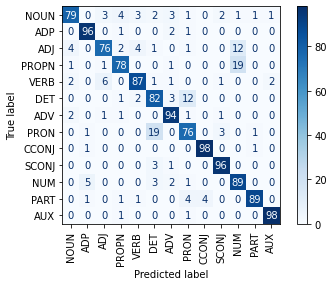

Confusion matrix for test_set


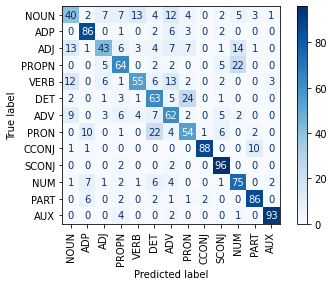

for train set:

              precision    recall  f1-score   support

        NOUN       0.90      0.79      0.84       100
         ADP       0.92      0.96      0.94       100
         ADJ       0.87      0.76      0.81       100
       PROPN       0.88      0.78      0.83       100
        VERB       0.90      0.87      0.88       100
         DET       0.74      0.82      0.78       100
         ADV       0.88      0.94      0.91       100
        PRON       0.78      0.76      0.77       100
       CCONJ       0.96      0.98      0.97       100
       SCONJ       0.93      0.96      0.95       100
         NUM       0.74      0.89      0.81       100
        PART       0.97      0.89      0.93       100
         AUX       0.97      0.98      0.98       100

    accuracy                           0.88      1300
   macro avg       0.88      0.88      0.88      1300
weighted avg       0.88      0.88      0.88      1300

for test set:

              precision    recall  f1-score   su

In [39]:
larrPD = np.array([pipe_my.predict([elm]) for elm in tqdm(larrDC)])
tarrPD = np.array([pipe_my.predict([elm]) for elm in tqdm(tarrDC)])

print("Confusion matrix for train_set")
ConfusionMatrixDisplay.from_predictions(larrLB,larrPD,display_labels = np.array(Classes),cmap = 'Blues',
                                        xticks_rotation = 'vertical')
pylab.show()

print("Confusion matrix for test_set")
ConfusionMatrixDisplay.from_predictions(tarrLB,tarrPD,display_labels = np.array(Classes),cmap = 'Blues',
                                        xticks_rotation = 'vertical')
pylab.show()

print("for train set:\n")
print(classification_report(larrLB,larrPD,target_names = np.array(Classes)))
print("for test set:\n")
print(classification_report(tarrLB,tarrPD,target_names = np.array(Classes)))

Версия skl (с теми же параметрами, обученная на том же датасете)

100%|█████████████████████████████████████████████████████████████████████████████| 1300/1300 [00:05<00:00, 250.63it/s]


Confusion matrix for train_set


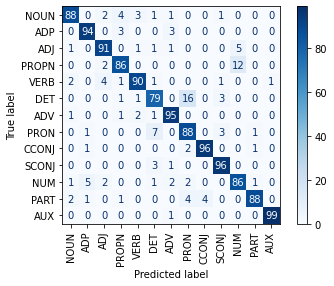

Confusion matrix for test_set


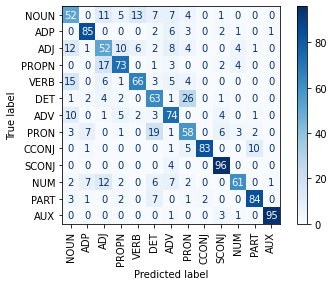

for train set:

              precision    recall  f1-score   support

        NOUN       0.93      0.88      0.90       100
         ADP       0.92      0.94      0.93       100
         ADJ       0.90      0.91      0.91       100
       PROPN       0.89      0.86      0.87       100
        VERB       0.93      0.90      0.91       100
         DET       0.84      0.79      0.81       100
         ADV       0.91      0.95      0.93       100
        PRON       0.79      0.88      0.83       100
       CCONJ       0.96      0.96      0.96       100
       SCONJ       0.92      0.96      0.94       100
         NUM       0.83      0.86      0.85       100
        PART       0.97      0.88      0.92       100
         AUX       0.99      0.99      0.99       100

    accuracy                           0.90      1300
   macro avg       0.91      0.90      0.90      1300
weighted avg       0.91      0.90      0.90      1300

for test set:

              precision    recall  f1-score   su

In [26]:
larrPD = np.array([pipe.predict([elm]) for elm in tqdm(larrDC)])
tarrPD = np.array([pipe.predict([elm]) for elm in tqdm(tarrDC)])

print("Confusion matrix for train_set")
ConfusionMatrixDisplay.from_predictions(larrLB,larrPD,display_labels = np.array(Classes),cmap = 'Blues',
                                        xticks_rotation = 'vertical')
pylab.show()

print("Confusion matrix for test_set")
ConfusionMatrixDisplay.from_predictions(tarrLB,tarrPD,display_labels = np.array(Classes),cmap = 'Blues',
                                        xticks_rotation = 'vertical')
pylab.show()

print("for train set:\n")
print(classification_report(larrLB,larrPD,target_names = np.array(Classes)))
print("for test set:\n")
print(classification_report(tarrLB,tarrPD,target_names = np.array(Classes)))

Сравнение с алгоритмом из skl показало, что собственная реализация дает, при прочих равных, несколько более низкую точность, чем версия из skl (0.7 против 0.72 на тестовой выборке). Также, собственная реализация крайне медленно работает в сравнении с skl-версией, так как последняя очень хорошо оптимизирована (пакетная функция как-никак).

### Определение оптимальных гиперпараметров
Мой алгоритм имеет два гиперпараметра: количество деревьев, максимальная глубина дерева и количество элементов в подвыборке

Так как мой алгоритм, очевидно, гораздо медленнее, чем алгоритм, представленный в skl, подбор будет производиться на алогритме из skl  

In [72]:
larrLB,larrDC,tarrLB,tarrDC = create_dataset(selLen = 10000, ClLen = 200)

In [76]:
rf = RandomForestClassifier()
pipe = Pipeline([('transformer',transform()),('classifier',rf)])

CrossValidataion = RCV([larrDC,larrLB],[tarrDC,tarrLB],pipe = pipe)
arr = CrossValidataion.validate(i = 10,ratio = 0.50,verbal = False)
mean_score = np.mean(arr)
print(mean_score)

0.8888461538461538


#### Построение зависимости [предельно допустимая глубина / точность]

In [89]:
arr_res = []
for i in range(1,100,5):
    rf = RandomForestClassifier(n_estimators = 100,max_depth = i,max_samples = 300)
    pipe = Pipeline([('transformer',transform()),('classifier',rf)])
    pipe.fit(larrDC.tolist(),larrLB.tolist())
    
    arr_res.append([i,pipe.score(larrDC.tolist(),larrLB.tolist()),pipe.score(tarrDC.tolist(),tarrLB.tolist())])

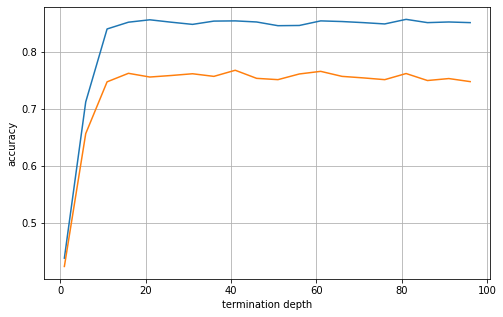

In [90]:
arr_res = np.array(arr_res,dtype = object)
res_arr = []
for i in arr_res:
    res_arr.append([i[0],i[1],i[2]])
res_arr = np.array(res_arr)

pylab.figure(figsize = [8,5])
pylab.grid()

pylab.xlabel('termination depth')
pylab.ylabel('accuracy')
pylab.plot(res_arr[:,0],res_arr[:,1])
pylab.plot(res_arr[:,0],res_arr[:,2])
pylab.show()

Определили, что предельная глубина деревьев повышает точность при возрастании, пока не больше 20, затем, вероятно, деревья уже имеют единичные элементы в листах.

#### Построение зависимости [количество деревьев / точность]

In [95]:
arr_res = []
for i in range(1,100,10):
    rf = RandomForestClassifier(n_estimators = i*10,max_depth = None,max_samples = 300)
    pipe = Pipeline([('transformer',transform()),('classifier',rf)])
    pipe.fit(larrDC.tolist(),larrLB.tolist())
    
    arr_res.append([i*10,pipe.score(larrDC.tolist(),larrLB.tolist()),pipe.score(tarrDC.tolist(),tarrLB.tolist())])

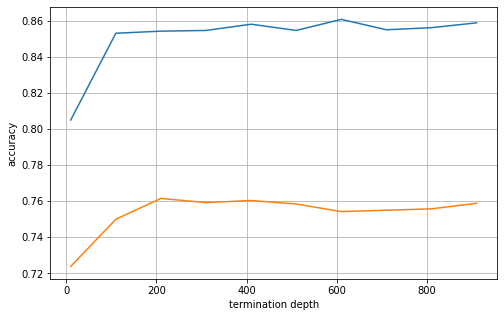

In [96]:
arr_res = np.array(arr_res,dtype = object)
res_arr = []
for i in arr_res:
    res_arr.append([i[0],i[1],i[2]])
res_arr = np.array(res_arr)

pylab.figure(figsize = [8,5])
pylab.grid()

pylab.xlabel('n_estimators')
pylab.ylabel('accuracy')
pylab.plot(res_arr[:,0],res_arr[:,1])
pylab.plot(res_arr[:,0],res_arr[:,2])
pylab.show()

Число деревьев 200+ обеспечивает примерно одинаковую точность

#### Построение зависимости [количество элементов в подвыборках бутстрапа / точность]

In [111]:
arr_res = []
for i in range(100,len(larrDC.tolist()),100):
    rf = RandomForestClassifier(n_estimators = 300,max_depth = None,max_samples = i)
    pipe = Pipeline([('transformer',transform()),('classifier',rf)])
    pipe.fit(larrDC.tolist(),larrLB.tolist())
    
    arr_res.append([i,pipe.score(larrDC.tolist(),larrLB.tolist()),pipe.score(tarrDC.tolist(),tarrLB.tolist())])

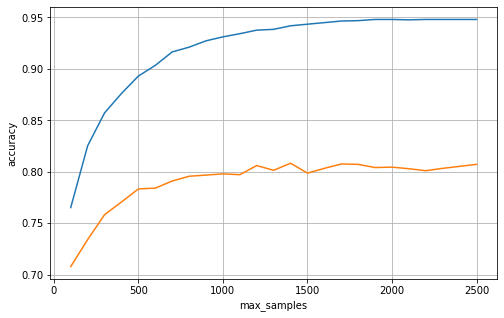

In [112]:
arr_res = np.array(arr_res,dtype = object)
res_arr = []
for i in arr_res:
    res_arr.append([i[0],i[1],i[2]])
res_arr = np.array(res_arr)

pylab.figure(figsize = [8,5])
pylab.grid()

pylab.xlabel('max_samples')
pylab.ylabel('accuracy')
pylab.plot(res_arr[:,0],res_arr[:,1])
pylab.plot(res_arr[:,0],res_arr[:,2])
pylab.show()

Чем больше элементов, тем лучше, однако, результат на тестовой выборке достигает предела, когда количество элементов в подвыборках бутстрапа = 1000, т.е. 0.4 от размеров исходных выборок

#### Построение зависимости [отношение размера тренировочной выборки к размеру тестовой / точность]
Эта зависимость актуальна для кросс-валидации, при выполнении которой обучающая и тестовая выборки, имеющие обычно равную длину, сливаются, а затем случайным образом делятся с определенным соотрошением

In [119]:
arr_res = []
for i in range(10,100,10):
    rf = RandomForestClassifier()
    pipe = Pipeline([('transformer',transform()),('classifier',rf)])

    CrossValidataion = RCV([larrDC,larrLB],[tarrDC,tarrLB],pipe = pipe)
    arr = CrossValidataion.validate(i = 10,ratio = i/100,verbal = False,do_train = True)
    mean_score_train = np.mean(arr[0])
    mean_score_test = np.mean(arr[1])
    
    arr_res.append([i/100,mean_score_train,mean_score_test])

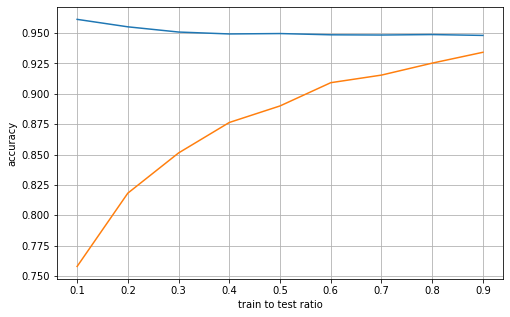

In [121]:
arr_res = np.array(arr_res,dtype = object)
res_arr = []
for i in arr_res:
    res_arr.append([i[0],i[1],i[2]])
res_arr = np.array(res_arr)

pylab.figure(figsize = [8,5])
pylab.grid()

pylab.xlabel('train to test ratio')
pylab.ylabel('accuracy')
pylab.plot(res_arr[:,0],res_arr[:,1])
pylab.plot(res_arr[:,0],res_arr[:,2])
pylab.show()

Видно, что с ростом размера обучающей выборки, повышается точность на тестовой и снижается переобучение. В дальнейшей работе я буду избегать мизерных размеров тестовой выборки (соотношений больше 0.9), чтобы она сохраняла репрезентативность.

### Обучение модели с оптимальными параметрами

In [43]:
larrLB,larrDC,tarrLB,tarrDC = create_dataset(selLen = 10000, ClLen = 1000)

Кросс-валидация

In [44]:
rf = RandomForestClassifier(n_estimators = 300,max_depth = None,max_samples = 6000)
pipe = Pipeline([('transformer',transform()),('classifier',rf)])

CrossValidataion = RCV([larrDC,larrLB],[tarrDC,tarrLB],pipe = pipe)
arr = CrossValidataion.validate(i = 10,ratio = 0.90,verbal = False,do_train = True)
mean_score_train = np.mean(arr[0])
mean_score_test = np.mean(arr[1])
print('CV score on train set (0.9)')
print(mean_score_train)
print('CV score on test set (0.9)')
print(mean_score_test)

CV score on train set (0.9)
0.9226709401709401
CV score on test set (0.9)
0.9082692307692308


#### Основные метрики для единичного классификатора

Используем соотношение обучающих данных к валидационным 0.9

In [47]:
ratio = 0.9

validation_array_X = np.concatenate([larrDC,tarrDC],axis = 0)
validation_array_Y = np.concatenate([larrLB,tarrLB],axis = 0)

cur_validation_array_X, cur_validation_array_Y = skl.utils.shuffle(validation_array_X,validation_array_Y)

train_X,test_X = np.split(cur_validation_array_X,
                          [int(len(cur_validation_array_X)*ratio)])
train_L,test_L = np.split(cur_validation_array_Y,
                          [int(len(cur_validation_array_Y)*ratio)])

train_X = train_X.tolist()
train_L = train_L.tolist()

test_X = test_X.tolist()
test_L = test_L.tolist()


rf = RandomForestClassifier(n_estimators = 300,max_depth = None,max_samples = 6000)
pipe = Pipeline([('transformer',transform()),('classifier',rf)])
pipe.fit(train_X,train_L)
print("score on train set")
print(pipe.score(train_X,train_L))
print("score on test set")
print(pipe.score(test_X,test_L))

score on train set
0.9135042735042735
score on test set
0.8992307692307693


100%|██████████████████████████████████████████████████████████████████████████████| 2600/2600 [01:44<00:00, 24.88it/s]


Confusion matrix for train_set


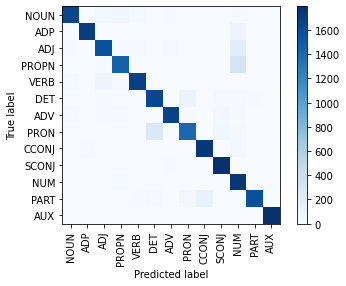

Confusion matrix for test_set


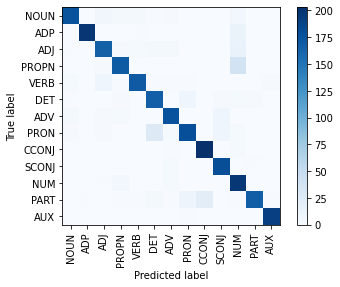

for train set:

              precision    recall  f1-score   support

        NOUN       0.96      0.91      0.93      1801
         ADP       0.98      0.94      0.96      1788
         ADJ       0.91      0.87      0.89      1807
       PROPN       0.91      0.81      0.86      1791
        VERB       0.97      0.93      0.95      1813
         DET       0.85      0.90      0.88      1815
         ADV       0.96      0.92      0.94      1805
        PRON       0.89      0.79      0.84      1777
       CCONJ       0.93      0.97      0.95      1793
       SCONJ       0.92      0.99      0.95      1816
         NUM       0.71      0.97      0.82      1794
        PART       0.98      0.88      0.92      1792
         AUX       1.00      0.99      0.99      1808

    accuracy                           0.91     23400
   macro avg       0.92      0.91      0.91     23400
weighted avg       0.92      0.91      0.91     23400

for test set:

              precision    recall  f1-score   su

In [49]:
larrPD = np.array([pipe.predict([elm])[0] for elm in tqdm(train_X)])
tarrPD = np.array([pipe.predict([elm])[0] for elm in tqdm(test_X)])

print("Confusion matrix for train_set")
ConfusionMatrixDisplay.from_predictions(train_L,larrPD,display_labels = np.array(Classes),cmap = 'Blues',
                                        xticks_rotation = 'vertical',include_values = False)
pylab.show()

print("Confusion matrix for test_set")
ConfusionMatrixDisplay.from_predictions(test_L,tarrPD,display_labels = np.array(Classes),cmap = 'Blues',
                                        xticks_rotation = 'vertical',include_values = False)
pylab.show()

print("for train set:\n")
print(classification_report(train_L,larrPD,target_names = np.array(Classes)))
print("for test set:\n")
print(classification_report(test_L,tarrPD,target_names = np.array(Classes)))

Наблюдается:
- Довольно низкое переобучение
- Точность на тестовом датасете (0.8992307692307693) выше, чем у модли со стандартными параметрамми (0.8569230769230769), что использовалась в л.р.1
- Когда я работал с выборкой из 7 классов (из этого же датасета), была достигнута точность в 0.903, что больше, чем точность на  выборке в 13 элементов меньше, чем на 0.01, что впечатляет.
- Увеличение точности на тестовом сете сопровождалось снижением точности на обучающем

### Вывод
В ходе выполнения курсовой работы, я поставил задачу классификации слов русского языка по частям речи, провел исследование датасета, определил оптимальные признаки и сформировал выборки (13 классов, сбаллансированные). Я выбрал случайный лес в качества алгоритма классификации и обосновал свой выбор, сравнив полученный результат (accuracy = 0.8547692307692307) с результатами других алгоритмов машинного обучения, точность которых была меньше (0.45 - 0.83).  
Я реализовал свою версию случайного леса, и получил точность 0.875 на обучающей выборке и 0.696 на тестовой. Алгоритм из skl при тех же гиперпараметрах дал точность 0.905 и 0.725 соответственно, что не так уж сильно больше.  
Затем я провел исследование зависимости точности от гиперпараметров алгоритма, и, определив их оптимальные значения, получил алгоритм, со средней точностью в 0.9082692307692308. При поиске оптимальных значений гипперпараметров я использовал версию алгоритма из skl, так как собственная реализация не оптимизирована и работает крайне медленно. Запускать собственный алгоритм при оптимальных гиперпараметрах я не стал, так как он бы работал часов 15.  